In [162]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import time

In [163]:
# tf.debugging.set_log_device_placement(True)

# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [164]:
DF_PATH = 'data/train.csv'
USE_COLUMNS = ['ETHUSD_Close_log','ZECUSD_Close_log','LTCUSD_Close_log','BTCUSD_Close_log']
TRAIN_SIZE = 0.7
TIME_WINDOW = 35
DATA_USE = 50000

In [165]:
# Read train file
train_df = pd.read_csv(DF_PATH)
train_df.sort_values('Date')
train_df.head()

,Date,ETHUSD_Volume,ZECUSD_Volume,LTCUSD_Volume,BTCUSD_Volume,ETHUSD_Open_log,ETHUSD_High_log,ETHUSD_Low_log,ETHUSD_Close_log,ZECUSD_Open_log,...,ZECUSD_Low_log,ZECUSD_Close_log,LTCUSD_Open_log,LTCUSD_High_log,LTCUSD_Low_log,LTCUSD_Close_log,BTCUSD_Open_log,BTCUSD_High_log,BTCUSD_Low_log,BTCUSD_Close_log
0,2019-03-19 00:00:00,2.506756,0.0,0.00000,0.000000,4.921294,4.921294,4.920492,4.920492,3.983785,...,3.983785,3.983785,4.073291,4.073291,4.073291,4.073291,8.283757,8.283757,8.283757,8.283757
1,2019-03-19 00:01:00,4.146010,0.0,0.00000,0.000000,4.920492,4.920492,4.919251,4.919251,3.983785,...,3.983785,3.983785,4.073291,4.073291,4.073291,4.073291,8.283757,8.283757,8.283757,8.283757
2,2019-03-19 00:02:00,10.000000,0.0,0.49999,0.000000,4.919251,4.919251,4.918885,4.918885,3.983785,...,3.983785,3.983785,4.073291,4.073291,4.073291,4.073291,8.283757,8.283757,8.283757,8.283757
3,2019-03-19 00:03:00,0.000000,0.0,33.62118,0.030867,4.918885,4.918885,4.918885,4.918885,3.983785,...,3.983785,3.983785,4.073291,4.073291,4.073291,4.073291,8.283757,8.284350,8.283757,8.284350
4,2019-03-19 00:04:00,0.000000,0.0,11.01871,2.286674,4.918885,4.918885,4.918885,4.918885,3.983785,...,3.983785,3.983785,4.073291,4.073291,4.073291,4.073291,8.284350,8.284353,8.283759,8.283759


In [99]:
# Check the dataset is sorted by "Date" 
# And tha last date is 2021/03/18, 23:59 
train_df.tail(-1440)

,Date,ETHUSD_Volume,ZECUSD_Volume,LTCUSD_Volume,BTCUSD_Volume,ETHUSD_Open_log,ETHUSD_High_log,ETHUSD_Low_log,ETHUSD_Close_log,ZECUSD_Open_log,...,ZECUSD_Low_log,ZECUSD_Close_log,LTCUSD_Open_log,LTCUSD_High_log,LTCUSD_Low_log,LTCUSD_Close_log,BTCUSD_Open_log,BTCUSD_High_log,BTCUSD_Low_log,BTCUSD_Close_log
1440,2019-03-20 00:00:00,0.000000,0.000000,0.00000,0.131882,4.923478,4.923478,4.923478,4.923478,4.017464,...,4.017464,4.017464,4.077029,4.077029,4.077029,4.077029,8.291155,8.291155,8.291155,8.291155
1441,2019-03-20 00:01:00,0.000000,0.000000,0.00000,0.126791,4.923478,4.923478,4.923478,4.923478,4.017464,...,4.017464,4.017464,4.077029,4.077029,4.077029,4.077029,8.291155,8.291155,8.291155,8.291155
1442,2019-03-20 00:02:00,3.999354,0.000000,98.40303,0.949663,4.923478,4.923478,4.923042,4.923042,4.017464,...,4.017464,4.017464,4.077029,4.077029,4.075501,4.075501,8.291155,8.291155,8.290739,8.290739
1443,2019-03-20 00:03:00,0.000000,0.000000,1.59000,0.004971,4.923042,4.923042,4.923042,4.923042,4.017464,...,4.017464,4.017464,4.075501,4.075501,4.075501,4.075501,8.290739,8.290739,8.289911,8.289911
1444,2019-03-20 00:04:00,0.461938,0.000000,0.00000,0.024851,4.923042,4.923042,4.921950,4.921950,4.017464,...,4.017464,4.017464,4.075501,4.075501,4.075501,4.075501,8.289911,8.290082,8.289911,8.290082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986791,2021-03-18 23:55:00,8.084875,0.000000,19.63536,0.042762,7.492693,7.493724,7.492693,7.493328,4.976734,...,4.976734,4.976734,5.312122,5.314191,5.312122,5.314191,10.972620,10.973400,10.972518,10.973400
986792,2021-03-18 23:56:00,2.986374,0.000000,6.27173,0.493466,7.493328,7.494503,7.492693,7.493351,4.976734,...,4.976734,4.976734,5.314191,5.314240,5.313748,5.313748,10.973400,10.974774,10.973400,10.974290
986793,2021-03-18 23:57:00,0.544132,10.407404,5.00000,0.291972,7.493351,7.493351,7.492036,7.492777,4.976734,...,4.975699,4.975699,5.313748,5.313748,5.311924,5.311924,10.974290,10.974387,10.973042,10.973915
986794,2021-03-18 23:58:00,3.994954,0.000000,223.58507,16.107329,7.492777,7.492894,7.491517,7.491729,4.975699,...,4.975699,4.975699,5.311924,5.312812,5.311579,5.312812,10.973915,10.973915,10.971722,10.972547


In [166]:
# Extract close price of coins
# I just use close price in this prediction
df1 = train_df[USE_COLUMNS]
df1.head()

,ETHUSD_Close_log,ZECUSD_Close_log,LTCUSD_Close_log,BTCUSD_Close_log
0,4.920492,3.983785,4.073291,8.283757
1,4.919251,3.983785,4.073291,8.283757
2,4.918885,3.983785,4.073291,8.283757
3,4.918885,3.983785,4.073291,8.284350
4,4.918885,3.983785,4.073291,8.283759


In [12]:
# Describe the dataframe
df1.describe()

,ETHUSD_Close_log,ZECUSD_Close_log,LTCUSD_Close_log,BTCUSD_Close_log,ETHUSD_Volume,ZECUSD_Volume,LTCUSD_Volume,BTCUSD_Volume
count,986796.000000,986796.000000,986796.000000,986796.000000,986796.000000,986796.000000,986796.000000,986796.000000
mean,5.663591,4.062616,4.226380,9.308898,14.945332,3.946617,13.322267,1.506834
std,0.704343,0.398676,0.451200,0.576290,82.781252,36.021433,87.634335,7.033323
min,4.487287,2.890927,3.216072,8.259145,0.000000,0.000000,0.000000,0.000000
25%,5.171733,3.807107,3.847164,8.991196,0.000000,0.000000,0.000000,0.006806
50%,5.436992,4.080246,4.096841,9.165258,0.049294,0.000000,0.000000,0.109110
75%,5.955760,4.287304,4.479947,9.364627,4.358356,0.000000,0.354722,0.814733
max,7.620636,5.258120,5.509145,11.031159,19261.261188,5194.896776,12429.159590,1043.579964


In [11]:
# Check the null values
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986796 entries, 0 to 986795
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ETHUSD_Close_log  986796 non-null  float64
 1   ZECUSD_Close_log  986796 non-null  float64
 2   LTCUSD_Close_log  986796 non-null  float64
 3   BTCUSD_Close_log  986796 non-null  float64
 4   ETHUSD_Volume     986796 non-null  float64
 5   ZECUSD_Volume     986796 non-null  float64
 6   LTCUSD_Volume     986796 non-null  float64
 7   BTCUSD_Volume     986796 non-null  float64
dtypes: float64(8)
memory usage: 60.2 MB


In [167]:
# Get the number of data
df1.shape

(986796, 4)

In [168]:
# scale all columns 
# I am not sure is it useful
scaler_ETH = MinMaxScaler(feature_range=(0,1))
scaler_ZEC = MinMaxScaler(feature_range=(0,1))
scaler_LTC = MinMaxScaler(feature_range=(0,1))
scaler_BTC = MinMaxScaler(feature_range=(0,1))

tmp1 = scaler_ETH.fit_transform(np.array(df1.ETHUSD_Close_log).reshape(-1,1))
tmp2 = scaler_ZEC.fit_transform(np.array(df1.ZECUSD_Close_log).reshape(-1,1))
tmp3 = scaler_LTC.fit_transform(np.array(df1.LTCUSD_Close_log).reshape(-1,1))
tmp4 = scaler_BTC.fit_transform(np.array(df1.BTCUSD_Close_log).reshape(-1,1))

# df2 : scaled dataframe
df2 = pd.DataFrame()
df2['ETHUSD_Close_log'] = tmp1.flatten().tolist()
df2['ZECUSD_Close_log'] = tmp2.flatten().tolist()
df2['LTCUSD_Close_log'] = tmp3.flatten().tolist()
df2['BTCUSD_Close_log'] = tmp4.flatten().tolist()

# scale all volumns
if len(df1.columns) > 4:
    scaler = MinMaxScaler(feature_range=(0,1))
    df2[['ETHUSD_Volume', 'ZECUSD_Volume', 'LTCUSD_Volume','BTCUSD_Volume']] = scaler.fit_transform(df1[['ETHUSD_Volume', 'ZECUSD_Volume', 'LTCUSD_Volume','BTCUSD_Volume']])

dict_scaler =  {'ETH':scaler_ETH, 'ZEC':scaler_ZEC, 'LTC':scaler_LTC, 'BTC':scaler_BTC}

In [169]:
# Get the recent dataset
df_t = df2[-DATA_USE:]
# For validation after creating model
df_a = df1[-DATA_USE:]

In [170]:
# Split dataset into train and test
train_size = int(len(df_t)*TRAIN_SIZE)
train_df = df_t[:train_size]
validation_df = df_t[train_size:]

print(train_df.shape, validation_df.shape)

(35000, 4) (15000, 4)


In [171]:
df_t.head()

,ETHUSD_Close_log,ZECUSD_Close_log,LTCUSD_Close_log,BTCUSD_Close_log
936796,0.958669,0.887234,0.873565,0.909094
936797,0.958004,0.887234,0.871957,0.908239
936798,0.958393,0.887119,0.873329,0.909288
936799,0.957499,0.882382,0.873329,0.908655
936800,0.957936,0.881131,0.869939,0.908919


In [172]:
# Create sequancial info dataset from dataframe
def create_seq_dataset(df, window=3):
  x_data = []
  y_data = []
  for i in range(len(df)-window):
    # pre_time data
    tmp = df[i:i+window]
    x_data.append(tmp)
    # target data
    y_data.append(df.iloc[i+window])
  return np.array(x_data), np.array(y_data)

In [173]:
# Create sequancial info dataset from dataframe
X_train, y_train = create_seq_dataset(train_df,TIME_WINDOW)
X_valid, y_valid = create_seq_dataset(validation_df,TIME_WINDOW)

In [174]:
# Get dataset shape info
print(f'Shape of X_train : {X_train.shape}')
print(f'Shape of y_train : {y_train.shape}')
print(f'Shape of X_valid : {X_valid.shape}')
print(f'Shape of y_valid : {y_valid.shape}')

Shape of X_train : (34965, 35, 4)
Shape of y_train : (34965, 4)
Shape of X_valid : (14965, 35, 4)
Shape of y_valid : (14965, 4)


## Model training only one Coin Price

In [85]:
# dictionary for extracting interesting TARGET info 
# Use it when train a model for specific Coin
# PRE_TARGET
dict_target = {'ETH':0,'ZEC':1,'LTC':2,'BTC':3}

In [74]:
# Set parameters
EPOCH = 100
BATCH_SIZE = 64
DESCRIBTION = '64_64_32_1'

for target in dict_target.keys():
    # Create LSTM model
    with tf.device('/device:GPU:1'):
        model = Sequential()

        model.add(LSTM(64, input_shape=(X_train.shape[1:]), return_sequences=True))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        
        model.add(LSTM(64, input_shape=(X_train.shape[1:]), return_sequences=True))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())

        model.add(LSTM(32))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())

        model.add(Dense(1))

        model.compile(loss='mean_squared_error', optimizer='adam')

    PRE_TARGET = target
    NAME = f'{DATA_USE}-{TIME_WINDOW}-window-{PRE_TARGET}-target-{DESCRIBTION}-{int(time.time())}'
    print(NAME)
    
    tensorboard = TensorBoard(log_dir=f'logs/{NAME}')

    mc = ModelCheckpoint(f'models/best_{NAME}.h5', monitor='val_loss', mode='min', save_best_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

    if PRE_TARGET != 'ALL':
        tmp_y_train = y_train[:,dict_target[PRE_TARGET]]
        tmp_y_valid = y_valid[:,dict_target[PRE_TARGET]]
    else :
        tmp_y_train = y_train
        tmp_y_valid = y_valid

    history = model.fit(
        X_train, tmp_y_train, 
        validation_data=(X_valid, tmp_y_valid), 
        epochs=EPOCH, 
        batch_size=BATCH_SIZE, 
        verbose=1,
        callbacks=[tensorboard, mc, es])
    
    model.save(f'models/{NAME}')

100000-100-window-ETH-target-64_64_32_1-1618822837
Epoch 1/100
1093/1093 [==============================] - 35s 29ms/step - loss: 0.4303 - val_loss: 4.9154e-04
Epoch 2/100
1093/1093 [==============================] - 31s 28ms/step - loss: 0.0082 - val_loss: 1.4536e-04
Epoch 3/100
1093/1093 [==============================] - 30s 28ms/step - loss: 3.7499e-04 - val_loss: 1.5133e-04
Epoch 4/100
1093/1093 [==============================] - 31s 28ms/step - loss: 2.6233e-04 - val_loss: 2.3832e-04
Epoch 5/100
1093/1093 [==============================] - 31s 28ms/step - loss: 2.0241e-04 - val_loss: 3.1085e-04
Epoch 6/100
1093/1093 [==============================] - 31s 28ms/step - loss: 1.8373e-04 - val_loss: 4.9842e-05
Epoch 7/100
1093/1093 [==============================] - 31s 28ms/step - loss: 1.6443e-04 - val_loss: 8.2646e-04
Epoch 8/100
1093/1093 [==============================] - 30s 28ms/step - loss: 1.5727e-04 - val_loss: 1.1949e-05
Epoch 9/100
1093/1093 [==============================

1093/1093 [==============================] - 30s 28ms/step - loss: 1.5197e-04 - val_loss: 1.8873e-04
Epoch 16/100
1093/1093 [==============================] - 30s 28ms/step - loss: 1.5246e-04 - val_loss: 5.2807e-05
Epoch 17/100
1093/1093 [==============================] - 30s 28ms/step - loss: 1.4855e-04 - val_loss: 4.4541e-04
Epoch 18/100
1093/1093 [==============================] - 30s 28ms/step - loss: 1.6271e-04 - val_loss: 9.0766e-04
Epoch 00018: early stopping


In [125]:
# Integrate prediction dataset from 4 prediction models

# best_model list for iteration
model_list ={'ETH':'100000-100-window-ETH-target-64_64_32_1-1618822837',
             'ZEC':'100000-100-window-ZEC-target-64_64_32_1-1618823391',
             'LTC':'100000-100-window-LTC-target-64_64_32_1-1618823761',
             'BTC':'100000-100-window-BTC-target-64_64_32_1-1618824549'   
}

# Make dataframe for integration
valid_prediction_df = pd.DataFrame(columns=dict_target.keys())
valid_prediction_df

# iterate and predict with each best model
for coin_name, model_name in model_list.items():
    # Load best model
    best_model = tf.keras.models.load_model(f'models/best_{model_name}.h5')
    
    # prediction with last 1440 data in validation dataset
    valid_prediction = best_model.predict(X_valid[-1440:])
    
    # Inverse transform the scaled data# 
    predict_list = []
    predict_list.append(dict_scaler[coin_name].inverse_transform(valid_prediction.reshape(-1,1)))
    
    # stack the predict results 
    valid_prediction = np.column_stack(predict_list)
    valid_prediction_df[coin_name] = valid_prediction.flatten().tolist()

# Convert dataframe into numpy    
valid_prediction = valid_prediction_df.to_numpy()

# Get actual validation data
valid_actual = df_a[-1440:].to_numpy()

# Calculate MAPE 
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

print('prediction results')
print(MAPE(valid_prediction,valid_actual))

prediction results
0.20348179672739344


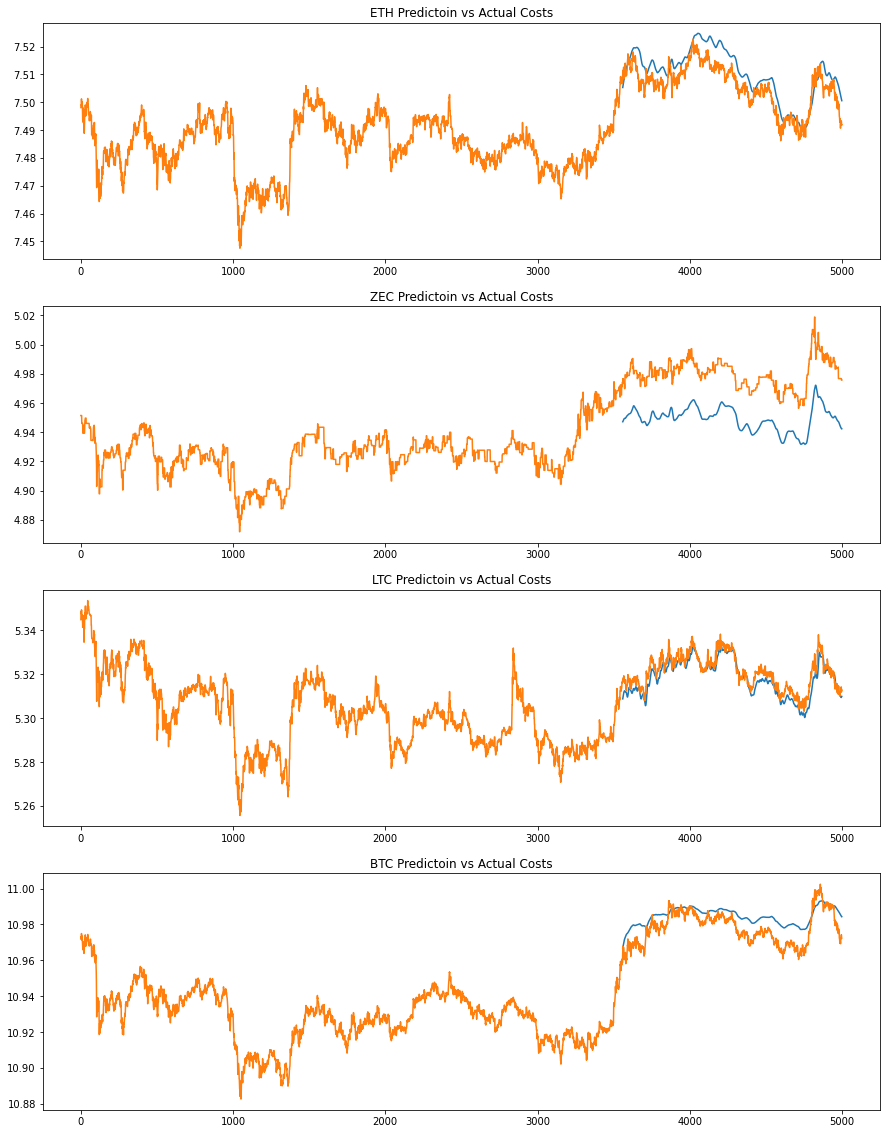

In [126]:
# Plotting the model prediction
pre_df = pd.DataFrame(valid_prediction, columns=[f'{k}_pre' for k in dict_target.keys()])
tmp_df = pd.DataFrame(np.nan, index=range(5000-1440), columns=[f'{k}_pre' for k in dict_target.keys()])

act_df = df_a[-5000:].reset_index(drop=True)
pre_df = pd.concat([tmp_df, pre_df]).reset_index(drop=True)

plot_df = pre_df.join(act_df)

plt.figure(figsize=(15,20))

for i, v in enumerate(dict_target.keys()):
    plt.subplot(4,1,i+1)
    plt.title(f'{v} Predictoin vs Actual Costs')
    plt.plot(plot_df[[f'{v}_pre',f'{v}USD_Close_log']])

plt.show()

## Test model (Only one coin Price ver.)

In [112]:
# best_model list for iteration
model_list ={'ETH':'100000-100-window-ETH-target-64_64_32_1-1618822837',
             'ZEC':'100000-100-window-ZEC-target-64_64_32_1-1618823391',
             'LTC':'100000-100-window-LTC-target-64_64_32_1-1618823761',
             'BTC':'100000-100-window-BTC-target-64_64_32_1-1618824549'   
}

tmp_list = []


# Get prediction for next 1day
output = []
input_x = X_valid[-1] # Information to predict the first 100 min.
n_step = TIME_WINDOW
i = 0
x_input = input_x.reshape(1,n_step,4)

# Load best model
best_model_ETH = tf.keras.models.load_model(f'models/best_{model_list["ETH"]}.h5')
best_model_ZEC = tf.keras.models.load_model(f'models/best_{model_list["ZEC"]}.h5')
best_model_LTC = tf.keras.models.load_model(f'models/best_{model_list["LTC"]}.h5')
best_model_BTC = tf.keras.models.load_model(f'models/best_{model_list["BTC"]}.h5')

while(i<1440):
    # predict with TIME_WINDOW information 
    predictions = []
    for b_model in [best_model_ETH, best_model_ZEC, best_model_LTC, best_model_BTC]:
        yhat = b_model.predict(x_input, verbose=0)
        predictions.append(yhat[0].tolist()[0])
        
    # Remove first information (out of the range of TIME_WINDOW)
    # And append predicted result to x_input
    x_input = np.append(x_input[0][1:],predictions)
    x_input = x_input.reshape(1,n_step,4)
    output.append(predictions)
    i = i+1
    if i % 100 == 0:
        print(i)

KeyboardInterrupt: 

In [156]:
# Inverse transform the scaled data# 
predict_list = []
for i, v in enumerate(dict_scaler.keys()):
    predict_list.append(dict_scaler[v].inverse_transform(np.array(output)[:,i].reshape(-1,1)))
# stack the predict results 
sub_prediction = np.column_stack(predict_list)


array([[ 7.50056108,  4.94234631,  5.30987595, 10.98430816],
       [ 7.50022827,  4.94201953,  5.30976483, 10.98404314],
       [ 7.4998215 ,  4.94143568,  5.30938486, 10.98368956],
       ...,
       [ 7.18433238,  4.27835277,  5.20111374, 10.29752125],
       [ 7.18432267,  4.27835334,  5.20111347, 10.29752141],
       [ 7.18431221,  4.27835376,  5.2011132 , 10.29752141]])

## Model training 4 Coins Price together

In [176]:
# Create LSTM model
with tf.device('/device:GPU:1'):
    model = Sequential()

    model.add(LSTM(64, input_shape=(X_train.shape[1:]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Dense(4))

    model.compile(loss='mean_absolute_percentage_error', optimizer='adam')

# model.add(LSTM(64, input_shape=X_train.shape[1:], return_sequences=True))
# model.add(LSTM(64, return_sequences=True))
# model.add(LSTM(64))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')

In [177]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 35, 64)            17664     
_________________________________________________________________
dropout_26 (Dropout)         (None, 35, 64)            0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 35, 64)            256       
_________________________________________________________________
lstm_27 (LSTM)               (None, 35, 64)            33024     
_________________________________________________________________
dropout_27 (Dropout)         (None, 35, 64)            0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 35, 64)            256       
_________________________________________________________________
lstm_28 (LSTM)               (None, 64)               

In [178]:
# Set parameters
EPOCH = 100
BATCH_SIZE = 64
PRE_TARGET = 'ALL'
DESCRIBTION = '64_64_64_4_MAPE'
NAME = f'{DATA_USE}-{TIME_WINDOW}-window-{PRE_TARGET}-target-{DESCRIBTION}-{int(time.time())}'

NAME

'50000-35-window-ALL-target-64_64_64_4_MAPE-1618836831'

In [179]:
tensorboard = TensorBoard(log_dir=f'logs/{NAME}')

mc = ModelCheckpoint(f'models/best_{NAME}.h5', monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

if PRE_TARGET != 'ALL':
    tmp_y_train = y_train[:,dict_target[PRE_TARGET]]
    tmp_y_valid = y_valid[:,dict_target[PRE_TARGET]]
else :
    tmp_y_train = y_train
    tmp_y_valid = y_valid

history = model.fit(
    X_train, tmp_y_train, 
    validation_data=(X_valid, tmp_y_valid), 
    epochs=EPOCH, 
    batch_size=BATCH_SIZE, 
    verbose=1,
    callbacks=[tensorboard, mc, es])

model.save(f'models/{NAME}')

Epoch 1/100
547/547 [==============================] - 13s 19ms/step - loss: 62.3847 - val_loss: 6.2568
Epoch 2/100
547/547 [==============================] - 9s 17ms/step - loss: 1.9881 - val_loss: 1.9954
Epoch 3/100
547/547 [==============================] - 9s 17ms/step - loss: 1.5185 - val_loss: 5.2663
Epoch 4/100
547/547 [==============================] - 9s 17ms/step - loss: 1.3380 - val_loss: 3.0351
Epoch 5/100
547/547 [==============================] - 9s 17ms/step - loss: 1.1777 - val_loss: 3.0624
Epoch 6/100
547/547 [==============================] - 9s 17ms/step - loss: 1.1202 - val_loss: 1.7708
Epoch 7/100
547/547 [==============================] - 9s 17ms/step - loss: 1.0416 - val_loss: 1.8567
Epoch 8/100
547/547 [==============================] - 9s 17ms/step - loss: 1.0025 - val_loss: 0.9151
Epoch 9/100
547/547 [==============================] - 9s 17ms/step - loss: 1.0103 - val_loss: 8.7313
Epoch 10/100
547/547 [==============================] - 9s 17ms/step - loss: 0.9

INFO:tensorflow:Assets written to: models/50000-35-window-ALL-target-64_64_64_4_MAPE-1618836831/assets


INFO:tensorflow:Assets written to: models/50000-35-window-ALL-target-64_64_64_4_MAPE-1618836831/assets


In [180]:
# Load best model
best_model = tf.keras.models.load_model(f'models/best_{NAME}.h5')

In [181]:
# prediction with last 1440 data in validation dataset
valid_prediction = best_model.predict(X_valid[-1440:])

In [182]:
valid_prediction

array([[0.96005034, 0.8667952 , 0.91678023, 0.9674949 ],
       [0.9601125 , 0.8668681 , 0.9169137 , 0.967637  ],
       [0.96017885, 0.8669532 , 0.91705334, 0.96778536],
       ...,
       [0.9587214 , 0.8693943 , 0.91794145, 0.9718287 ],
       [0.9586564 , 0.869275  , 0.91787046, 0.97176474],
       [0.9585906 , 0.8691599 , 0.9177997 , 0.97169757]], dtype=float32)

In [183]:
# Inverse transform the scaled data# 
predict_list = []
for i, v in enumerate(dict_scaler.keys()):
    predict_list.append(dict_scaler[v].inverse_transform(valid_prediction[:,i].reshape(-1,1)))
# stack the predict results 
valid_prediction = np.column_stack(predict_list)

In [184]:
valid_prediction

array([[ 7.49546  ,  4.9427986,  5.3183165, 10.941054 ],
       [ 7.495655 ,  4.942971 ,  5.3186226, 10.941448 ],
       [ 7.4958625,  4.9431725,  5.3189425, 10.94186  ],
       ...,
       [ 7.491296 ,  4.9489512,  5.320979 , 10.953068 ],
       [ 7.4910927,  4.9486685,  5.3208165, 10.95289  ],
       [ 7.4908867,  4.9483967,  5.3206544, 10.952704 ]], dtype=float32)

In [185]:
# Get actual validation data
valid_actual = df_a[-1440:].to_numpy()
valid_actual = valid_actual[:,:4]

In [186]:
# Calculate MAPE 
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

MAPE(valid_prediction,valid_actual)

0.250961974668127

## Plot the predictions

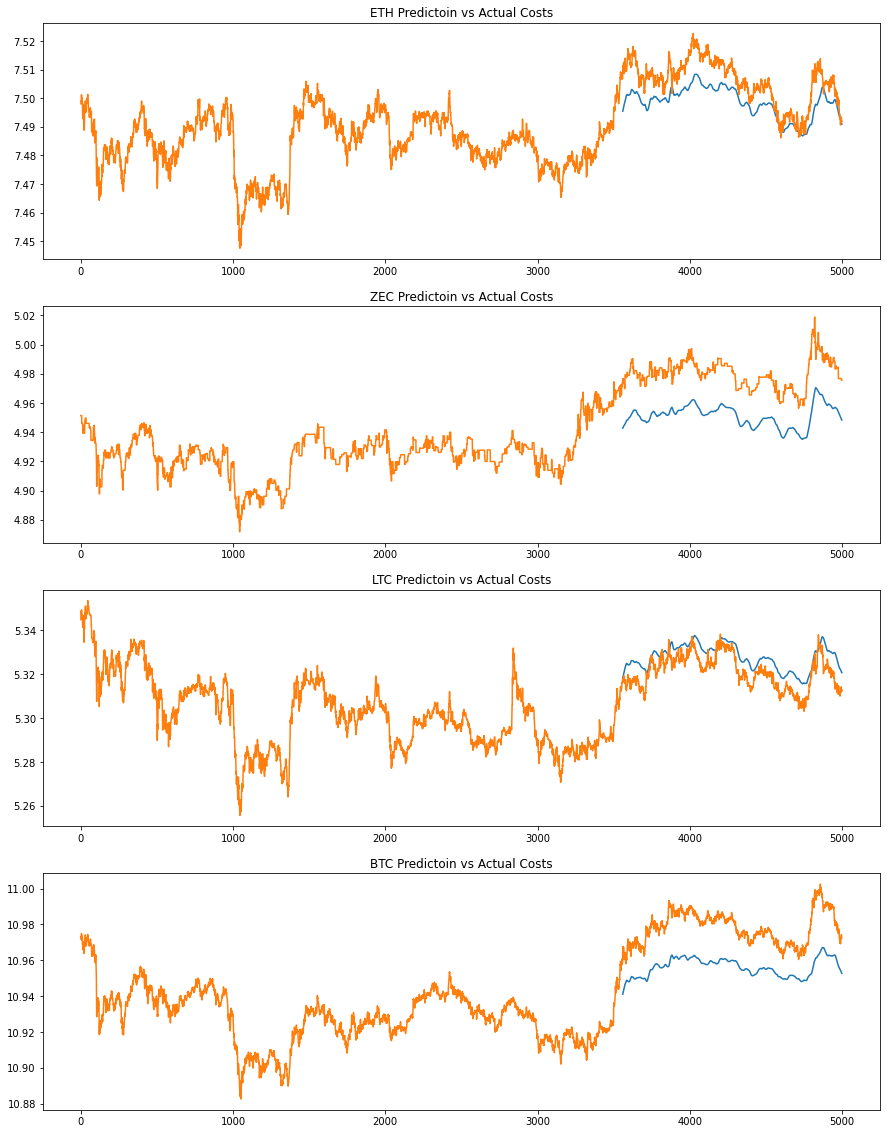

In [187]:
# Plotting the model prediction
pre_df = pd.DataFrame(valid_prediction, columns=[f'{k}_pre' for k in dict_target.keys()])
tmp_df = pd.DataFrame(np.nan, index=range(5000-1440), columns=[f'{k}_pre' for k in dict_target.keys()])

act_df = df_a[-5000:].reset_index(drop=True)
pre_df = pd.concat([tmp_df, pre_df]).reset_index(drop=True)

plot_df = pre_df.join(act_df)

plt.figure(figsize=(15,20))

for i, v in enumerate(dict_target.keys()):
    plt.subplot(4,1,i+1)
    plt.title(f'{v} Predictoin vs Actual Costs')
    plt.plot(plot_df[[f'{v}_pre',f'{v}USD_Close_log']])

plt.show()

## Test and Get prediction Future prices

In [188]:
# Load best model
best_model = tf.keras.models.load_model(f'models/best_{NAME}.h5')

# Get prediction for next 1day
output = []
input_x = X_valid[-1] # Information to predict the first 100 min.
n_step = TIME_WINDOW
i = 0

x_input = input_x.reshape(1,n_step,4)

while(i<1440):
    yhat = best_model.predict(x_input, verbose=0)
    x_input = np.append(x_input[0][1:],yhat[0].tolist())
    x_input = x_input.reshape(1,n_step,4)
    output.extend(yhat.tolist())
    i = i+1

In [189]:
# Inverse transform the scaled data# 
predict_list = []
for i, v in enumerate(dict_scaler.keys()):
    predict_list.append(dict_scaler[v].inverse_transform(np.array(output)[:,i].reshape(-1,1)))
# stack the predict results 
sub_prediction = np.column_stack(predict_list)
sub_prediction

array([[ 7.49088643,  4.94839649,  5.32065423, 10.95270427],
       [ 7.49064849,  4.94798562,  5.32048324, 10.95249559],
       [ 7.49035509,  4.94744297,  5.32026592, 10.95215754],
       ...,
       [ 7.46128182,  4.88963211,  5.29429003, 10.92813053],
       [ 7.46128182,  4.88963211,  5.29429003, 10.92813053],
       [ 7.46128182,  4.88963211,  5.29429003, 10.92813053]])

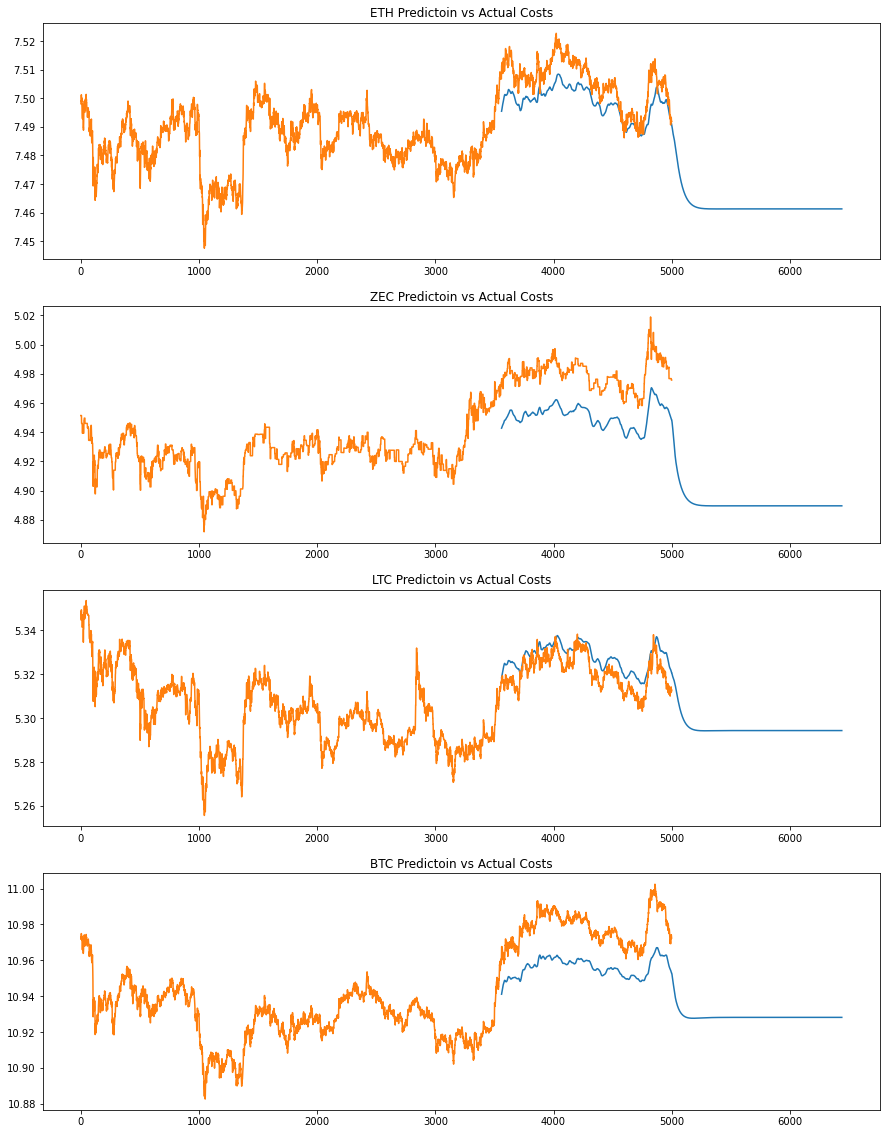

In [201]:
# Plotting the model prediction
pre_df = pd.DataFrame(valid_prediction, columns=[f'{k}_pre' for k in dict_target.keys()])
tmp_df = pd.DataFrame(np.nan, index=range(5000-1440), columns=[f'{k}_pre' for k in dict_target.keys()])

act_df = df_a[-5000:].reset_index(drop=True)
pre_df = pd.concat([tmp_df, pre_df]).reset_index(drop=True)
pre_df = pd.concat([pre_df, pd.DataFrame(sub_prediction,columns=[f'{k}_pre' for k in dict_target.keys()])]).reset_index(drop=True)

plot_df = pre_df.join(act_df)

plt.figure(figsize=(15,20))

for i, v in enumerate(dict_target.keys()):
    plt.subplot(4,1,i+1)
    plt.title(f'{v} Predictoin vs Actual Costs')
    plt.plot(plot_df[[f'{v}_pre',f'{v}USD_Close_log']])

plt.show()

In [200]:

pd.concat([pre_df, pd.DataFrame(sub_prediction,columns=[f'{k}_pre' for k in dict_target.keys()])]).reset_index(drop=True)

,ETH_pre,ZEC_pre,LTC_pre,BTC_pre
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
6435,7.461282,4.889632,5.29429,10.928131
6436,7.461282,4.889632,5.29429,10.928131
6437,7.461282,4.889632,5.29429,10.928131
6438,7.461282,4.889632,5.29429,10.928131


## Make submit file

In [190]:
sub_file = pd.read_csv('data/sample_submission.csv')
desc = NAME

pre_1 = sub_prediction[:,0].tolist()
pre_2 = sub_prediction[:,1].tolist()
pre_3 = sub_prediction[:,2].tolist()
pre_4 = sub_prediction[:,3].tolist()

sub_file['ETHUSD_Close_log'] = pre_1
sub_file['ZECUSD_Close_log'] = pre_2
sub_file['LTCUSD_Close_log'] = pre_3
sub_file['BTCUSD_Close_log'] = pre_4

sub_file.to_csv(f'data/test_sub_{desc}.csv', index=False)

In [191]:
pd.read_csv(f'data/test_sub_{desc}.csv')

,Date,ETHUSD_Close_log,ZECUSD_Close_log,LTCUSD_Close_log,BTCUSD_Close_log
0,00:00:00,7.490886,4.948396,5.320654,10.952704
1,00:01:00,7.490648,4.947986,5.320483,10.952496
2,00:02:00,7.490355,4.947443,5.320266,10.952158
3,00:03:00,7.490038,4.946816,5.320033,10.951744
4,00:04:00,7.489713,4.946123,5.319797,10.951277
...,...,...,...,...,...
1435,23:55:00,7.461282,4.889632,5.294290,10.928131
1436,23:56:00,7.461282,4.889632,5.294290,10.928131
1437,23:57:00,7.461282,4.889632,5.294290,10.928131
1438,23:58:00,7.461282,4.889632,5.294290,10.928131


In [317]:
0.6

,Date,ETHUSD_Close_log,ZECUSD_Close_log,LTCUSD_Close_log,BTCUSD_Close_log
0,00:00:00,7.501515,4.977207,5.331532,10.927858
1,00:01:00,7.501629,4.977484,5.331929,10.927977
2,00:02:00,7.501986,4.978034,5.332710,10.928178
3,00:03:00,7.502527,4.978713,5.333758,10.928409
4,00:04:00,7.503171,4.979380,5.334933,10.928612
...,...,...,...,...,...
1435,23:55:00,7.525734,4.928570,5.327002,10.877278
1436,23:56:00,7.525734,4.928570,5.327002,10.877278
1437,23:57:00,7.525734,4.928570,5.327002,10.877278
1438,23:58:00,7.525734,4.928570,5.327002,10.877278
